In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def get_config(self):
        config = super(Distiller, self).get_config()
        config.update({
            "student": self.student,
            "teacher": self.teacher
        })
        return config

    @classmethod
    def from_config(cls, config):
        student = config.pop("student")
        teacher = config.pop("teacher")
        return cls(student=student, teacher=teacher)

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            
            student_loss = self.student_loss_fn(
                y, 
                student_predictions,
                sample_weight=sample_weight
            )
            
            # Calculate sparse categorical crossentropy
            sparse_categorical_crossentropy = tf.keras.metrics.sparse_categorical_crossentropy(
                y, student_predictions
            )
            
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
                sample_weight=sample_weight
            ) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

      
        self.compiled_metrics.update_state(y, student_predictions, sample_weight=sample_weight)

        
        results = {m.name: m.result() for m in self.metrics}
        
       
        results.update({
            "student_loss": student_loss,
            "distillation_loss": distillation_loss,
            "sparse_categorical_crossentropy": tf.reduce_mean(sparse_categorical_crossentropy)
        })
        
        return results

    def test_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        student_predictions = self.student(x, training=False)
        
        student_loss = self.student_loss_fn(
            y, 
            student_predictions,
            sample_weight=sample_weight
        )
        
       
        sparse_categorical_crossentropy = tf.keras.metrics.sparse_categorical_crossentropy(
            y, student_predictions
        )

        
        self.compiled_metrics.update_state(y, student_predictions, sample_weight=sample_weight)

        results = {m.name: m.result() for m in self.metrics}
        

        results.update({
            "student_loss": student_loss,
            "sparse_categorical_crossentropy": tf.reduce_mean(sparse_categorical_crossentropy)
        })
            
        return results

    def call(self, inputs, training=None):
        return self.student(inputs, training=training)

In [3]:
import os
print("Directory exists:", os.path.exists(r'input/train_split'))
print("Directory contents:", os.listdir(r'input/train_split'))

img_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = img_gen.flow_from_directory(
    r'input/train_split',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = img_gen.flow_from_directory(
    r'input/train_split',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Directory exists: True
Directory contents: ['0', '1', '4', '3', '2']
Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [4]:
# Load DenseNet-201 model without the top layers (pre-trained on ImageNet)
densenet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Create the teacher model
teacher = models.Sequential([
    densenet201_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Create the student model
student = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(48, (5, 5), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),


    layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(5, activation='softmax')
])

student.summary()

2024-12-11 11:02:17.885633: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2024-12-11 11:02:17.885658: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 11:02:17.885665: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 11:02:17.885723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 11:02:17.885903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 48)      3648      
                                                                 
 re_lu (ReLU)                (None, 112, 112, 48)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 48)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        27712     
                                                                 
 re_lu_1 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                 

In [5]:
class MaxMinMetricsTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MaxMinMetricsTracker, self).__init__()
        self.max_accuracy = float('-inf')
        self.min_crossentropy = float('inf')
        self.max_val_accuracy = float('-inf')
        self.min_val_crossentropy = float('inf')
        self.min_student_loss = float('inf')
        self.min_distillation_loss = float('inf')
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            raise ValueError("Logs cannot be None")
            
        # Ensure all required metrics are present
        required_metrics = [
            'accuracy',
            'sparse_categorical_crossentropy',
            'val_accuracy',
            'val_sparse_categorical_crossentropy',
            'student_loss',
            'distillation_loss'
        ]
        
        missing_metrics = [metric for metric in required_metrics if metric not in logs]
        if missing_metrics:
            raise ValueError(f"Missing required metrics: {missing_metrics}")
        
        # Update best metrics
        if logs['accuracy'] > self.max_accuracy:
            self.max_accuracy = logs['accuracy']
        
        if logs['sparse_categorical_crossentropy'] < self.min_crossentropy:
            self.min_crossentropy = logs['sparse_categorical_crossentropy']
            
        if logs['val_accuracy'] > self.max_val_accuracy:
            self.max_val_accuracy = logs['val_accuracy']
            
        if logs['val_sparse_categorical_crossentropy'] < self.min_val_crossentropy:
            self.min_val_crossentropy = logs['val_sparse_categorical_crossentropy']
            
        if logs['student_loss'] < self.min_student_loss:
            self.min_student_loss = logs['student_loss']
            
        if logs['distillation_loss'] < self.min_distillation_loss:
            self.min_distillation_loss = logs['distillation_loss']
        
        # Print current best metrics
        print(f"\nEpoch {epoch + 1} - Best Metrics:")
        print(f"Max accuracy: {self.max_accuracy:.4f}")
        print(f"Min crossentropy: {self.min_crossentropy:.4f}")
        print(f"Max val_accuracy: {self.max_val_accuracy:.4f}")
        print(f"Min val_crossentropy: {self.min_val_crossentropy:.4f}")
        print(f"Min student_loss: {self.min_student_loss:.4f}")
        print(f"Min distillation_loss: {self.min_distillation_loss:.4f}")


callbacks = [
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_og',
        monitor='val_sparse_categorical_crossentropy',
        save_best_only=True,
        mode='min',
        save_weights_only=False,
        verbose=1
    ),
    
    MaxMinMetricsTracker()
]

In [6]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=1e-4,
        clipnorm=1.0,
        clipvalue=0.5 
    ),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseCategoricalCrossentropy(name='sparse_categorical_crossentropy')
    ],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6.0
)


history = distiller.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25


2024-12-11 11:02:23.816105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - accuracy: 0.4858 - sparse_categorical_crossentropy: 1.1197 - student_loss: 1.3782 - distillation_loss: 0.0113
Epoch 1: val_sparse_categorical_crossentropy improved from inf to 1.11452, saving model to best_model_og
INFO:tensorflow:Assets written to: best_model_og/assets


INFO:tensorflow:Assets written to: best_model_og/assets



Epoch 1 - Best Metrics:
Max accuracy: 0.4858
Min crossentropy: 1.1197
Max val_accuracy: 0.4938
Min val_crossentropy: 1.1145
Min student_loss: 1.1197
Min distillation_loss: 0.0055
92/92 [==============================] - 172s 2s/step - accuracy: 0.4858 - sparse_categorical_crossentropy: 1.1197 - student_loss: 1.3754 - distillation_loss: 0.0112 - val_accuracy: 0.4938 - val_sparse_categorical_crossentropy: 1.1145 - val_student_loss: 1.1145
Epoch 2/25
92/92 [==============================] - ETA: 0s - accuracy: 0.4927 - sparse_categorical_crossentropy: 1.2688 - student_loss: 1.2441 - distillation_loss: 0.0058
Epoch 2: val_sparse_categorical_crossentropy did not improve from 1.11452

Epoch 2 - Best Metrics:
Max accuracy: 0.4927
Min crossentropy: 1.1197
Max val_accuracy: 0.4938
Min val_crossentropy: 1.1145
Min student_loss: 1.1197
Min distillation_loss: 0.0054
92/92 [==============================] - 155s 2s/step - accuracy: 0.4927 - sparse_categorical_crossentropy: 1.2688 - student_loss: 1

INFO:tensorflow:Assets written to: best_model_og/assets



Epoch 3 - Best Metrics:
Max accuracy: 0.4964
Min crossentropy: 1.1197
Max val_accuracy: 0.4938
Min val_crossentropy: 0.9101
Min student_loss: 1.1197
Min distillation_loss: 0.0054
92/92 [==============================] - 172s 2s/step - accuracy: 0.4964 - sparse_categorical_crossentropy: 1.2926 - student_loss: 1.1276 - distillation_loss: 0.0097 - val_accuracy: 0.4938 - val_sparse_categorical_crossentropy: 0.9101 - val_student_loss: 0.9101
Epoch 4/25
92/92 [==============================] - ETA: 0s - accuracy: 0.6247 - sparse_categorical_crossentropy: 0.8984 - student_loss: 1.0046 - distillation_loss: 0.0150
Epoch 4: val_sparse_categorical_crossentropy did not improve from 0.91012

Epoch 4 - Best Metrics:
Max accuracy: 0.6247
Min crossentropy: 0.8984
Max val_accuracy: 0.6594
Min val_crossentropy: 0.9101
Min student_loss: 0.8984
Min distillation_loss: 0.0054
92/92 [==============================] - 154s 2s/step - accuracy: 0.6247 - sparse_categorical_crossentropy: 0.8984 - student_loss: 1

INFO:tensorflow:Assets written to: best_model_og/assets



Epoch 5 - Best Metrics:
Max accuracy: 0.6783
Min crossentropy: 0.8984
Max val_accuracy: 0.6594
Min val_crossentropy: 0.7236
Min student_loss: 0.8984
Min distillation_loss: 0.0054
92/92 [==============================] - 171s 2s/step - accuracy: 0.6783 - sparse_categorical_crossentropy: 1.0904 - student_loss: 0.9471 - distillation_loss: 0.0171 - val_accuracy: 0.6320 - val_sparse_categorical_crossentropy: 0.7236 - val_student_loss: 0.7236
Epoch 6/25
92/92 [==============================] - ETA: 0s - accuracy: 0.7049 - sparse_categorical_crossentropy: 0.7116 - student_loss: 0.8952 - distillation_loss: 0.0195
Epoch 6: val_sparse_categorical_crossentropy did not improve from 0.72362

Epoch 6 - Best Metrics:
Max accuracy: 0.7049
Min crossentropy: 0.7116
Max val_accuracy: 0.7073
Min val_crossentropy: 0.7236
Min student_loss: 0.7116
Min distillation_loss: 0.0054
92/92 [==============================] - 155s 2s/step - accuracy: 0.7049 - sparse_categorical_crossentropy: 0.7116 - student_loss: 0

INFO:tensorflow:Assets written to: best_model_og/assets



Epoch 10 - Best Metrics:
Max accuracy: 0.7148
Min crossentropy: 0.7116
Max val_accuracy: 0.7168
Min val_crossentropy: 0.6588
Min student_loss: 0.7116
Min distillation_loss: 0.0054
92/92 [==============================] - 173s 2s/step - accuracy: 0.7148 - sparse_categorical_crossentropy: 0.9261 - student_loss: 0.8633 - distillation_loss: 0.0209 - val_accuracy: 0.6662 - val_sparse_categorical_crossentropy: 0.6588 - val_student_loss: 0.6588
Epoch 11/25
92/92 [==============================] - ETA: 0s - accuracy: 0.7178 - sparse_categorical_crossentropy: 0.7573 - student_loss: 0.8595 - distillation_loss: 0.0210
Epoch 11: val_sparse_categorical_crossentropy did not improve from 0.65883

Epoch 11 - Best Metrics:
Max accuracy: 0.7178
Min crossentropy: 0.7116
Max val_accuracy: 0.7168
Min val_crossentropy: 0.6588
Min student_loss: 0.7116
Min distillation_loss: 0.0054
92/92 [==============================] - 157s 2s/step - accuracy: 0.7178 - sparse_categorical_crossentropy: 0.7573 - student_los

INFO:tensorflow:Assets written to: best_model_og/assets



Epoch 14 - Best Metrics:
Max accuracy: 0.7178
Min crossentropy: 0.6952
Max val_accuracy: 0.7196
Min val_crossentropy: 0.6424
Min student_loss: 0.6952
Min distillation_loss: 0.0054
92/92 [==============================] - 174s 2s/step - accuracy: 0.7175 - sparse_categorical_crossentropy: 1.2039 - student_loss: 0.8508 - distillation_loss: 0.0213 - val_accuracy: 0.6990 - val_sparse_categorical_crossentropy: 0.6424 - val_student_loss: 0.6424
Epoch 15/25
92/92 [==============================] - ETA: 0s - accuracy: 0.7172 - sparse_categorical_crossentropy: 0.7937 - student_loss: 0.8468 - distillation_loss: 0.0215
Epoch 15: val_sparse_categorical_crossentropy did not improve from 0.64243

Epoch 15 - Best Metrics:
Max accuracy: 0.7178
Min crossentropy: 0.6952
Max val_accuracy: 0.7196
Min val_crossentropy: 0.6424
Min student_loss: 0.6952
Min distillation_loss: 0.0054
92/92 [==============================] - 160s 2s/step - accuracy: 0.7172 - sparse_categorical_crossentropy: 0.7937 - student_los

In [7]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Read the test CSV file
test_df = pd.read_csv('input/aptos2019-blindness-detection/test.csv')


# Load the best model
best_model = tf.keras.models.load_model('best_model_og')

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Process all images and make predictions
predictions = []
processed_files = []
test_dir = 'input/aptos2019-blindness-detection/test_images'

try:
    # Verify test directory exists
    if not os.path.exists(test_dir):
        raise ValueError(f"Test directory not found: {test_dir}")
    
    print(f"Processing images from: {test_dir}")
    
    # Process each image in the test directory
    for img_name in os.listdir(test_dir):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_dir, img_name)
            
            # Load and preprocess image
            img_array = load_and_preprocess_image(img_path)
            
            # Make prediction
            pred = best_model.predict(img_array, verbose=0)
            predictions.append(pred[0])
            
            # Store filename without extension
            processed_files.append(os.path.splitext(img_name)[0])
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'id_code': processed_files,
        'predicted_class': predicted_classes
    })
    
    # Sort results to match test.csv order
    results_df = results_df.set_index('id_code').reindex(test_df['id_code']).reset_index()
    
    print("\nPrediction Results:")
    print(results_df.head())
    
    # Save predictions to CSV
    results_df.to_csv('test_predictions.csv', index=False)
    
    # Print distribution of predictions
    print("\nDistribution of predictions:")
    print(pd.Series(predicted_classes).value_counts().sort_index())
    
    print(f"\nTotal images processed: {len(processed_files)}")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise

Processing images from: input/aptos2019-blindness-detection/test_images

Prediction Results:
        id_code  predicted_class
0  0005cfc8afb6                2
1  003f0afdcd15                2
2  006efc72b638                2
3  00836aaacf06                2
4  009245722fa4                2

Distribution of predictions:
0     569
2    1359
Name: count, dtype: int64

Total images processed: 1928


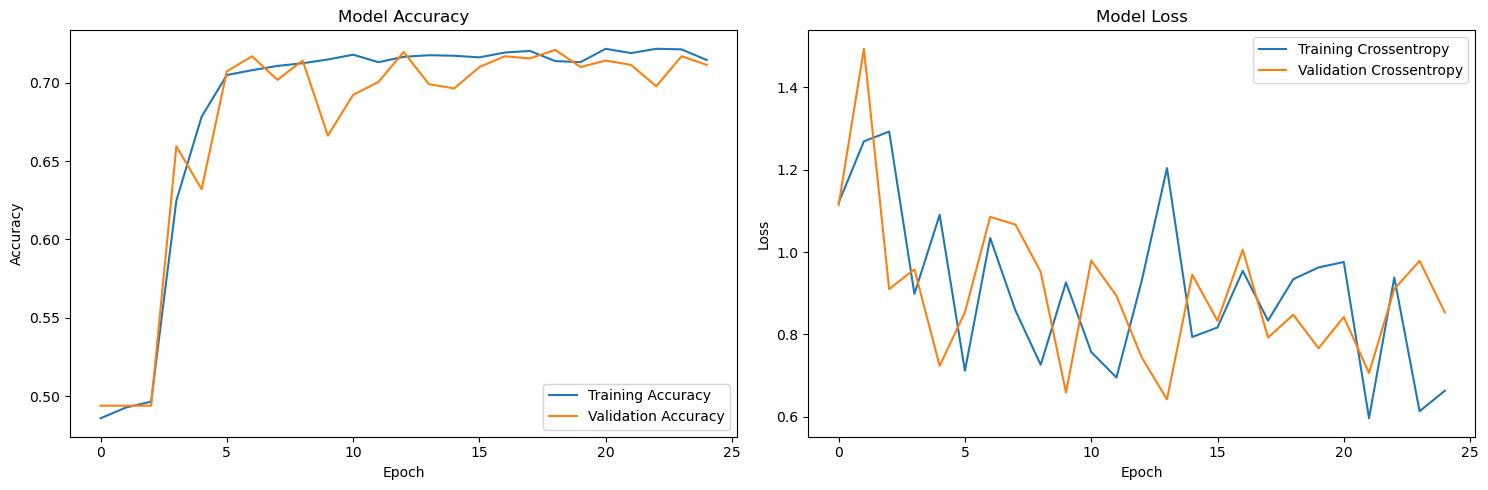

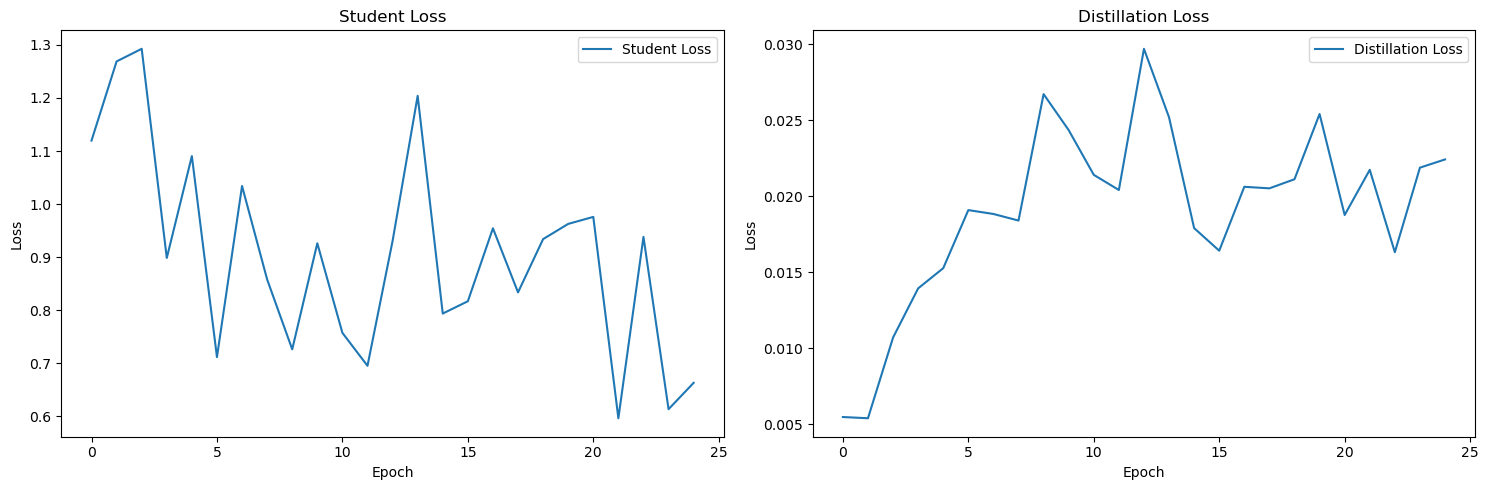


Best Training Metrics:
Best Training Accuracy: 0.7216
Best Validation Accuracy: 0.7209
Best Training Crossentropy: 0.5964
Best Validation Crossentropy: 0.6424
Best Student Loss: 0.5964
Best Distillation Loss: 0.0054


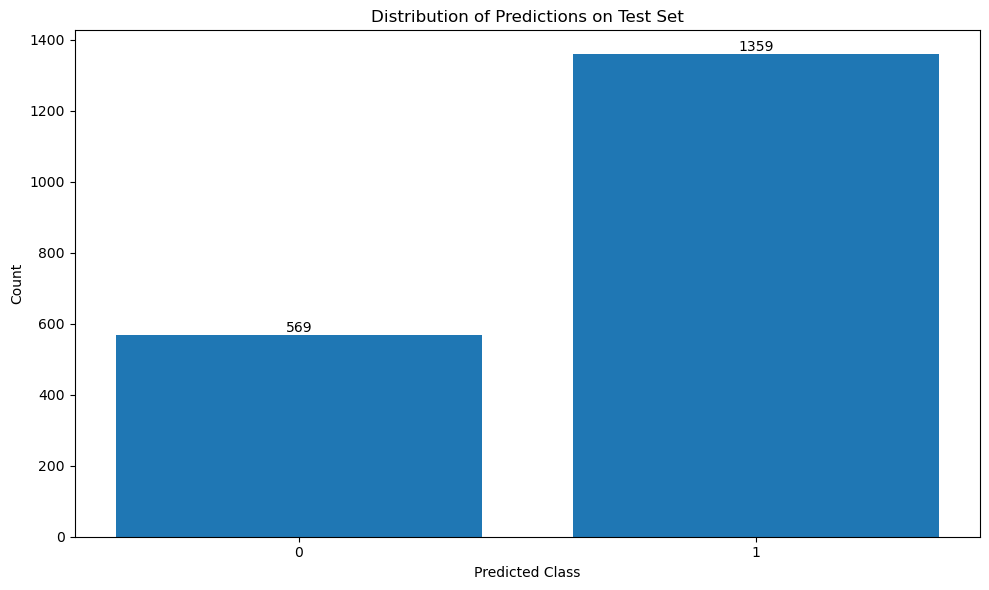

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy metrics
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss metrics
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_crossentropy'], label='Training Crossentropy')
plt.plot(history.history['val_sparse_categorical_crossentropy'], label='Validation Crossentropy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot additional training metrics
plt.figure(figsize=(15, 5))

# Plot student loss
plt.subplot(1, 2, 1)
plt.plot(history.history['student_loss'], label='Student Loss')
plt.title('Student Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot distillation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['distillation_loss'], label='Distillation Loss')
plt.title('Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final best metrics
print("\nBest Training Metrics:")
print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Training Crossentropy: {min(history.history['sparse_categorical_crossentropy']):.4f}")
print(f"Best Validation Crossentropy: {min(history.history['val_sparse_categorical_crossentropy']):.4f}")
print(f"Best Student Loss: {min(history.history['student_loss']):.4f}")
print(f"Best Distillation Loss: {min(history.history['distillation_loss']):.4f}")

# Plot prediction distribution for test set
plt.figure(figsize=(10, 6))
pred_dist = pd.Series(predicted_classes).value_counts().sort_index()
plt.bar(range(len(pred_dist)), pred_dist.values)
plt.title('Distribution of Predictions on Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.xticks(range(len(pred_dist)))

# Add value labels on top of bars
for i, v in enumerate(pred_dist.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

23/23 [==============================] - 35s 1s/step


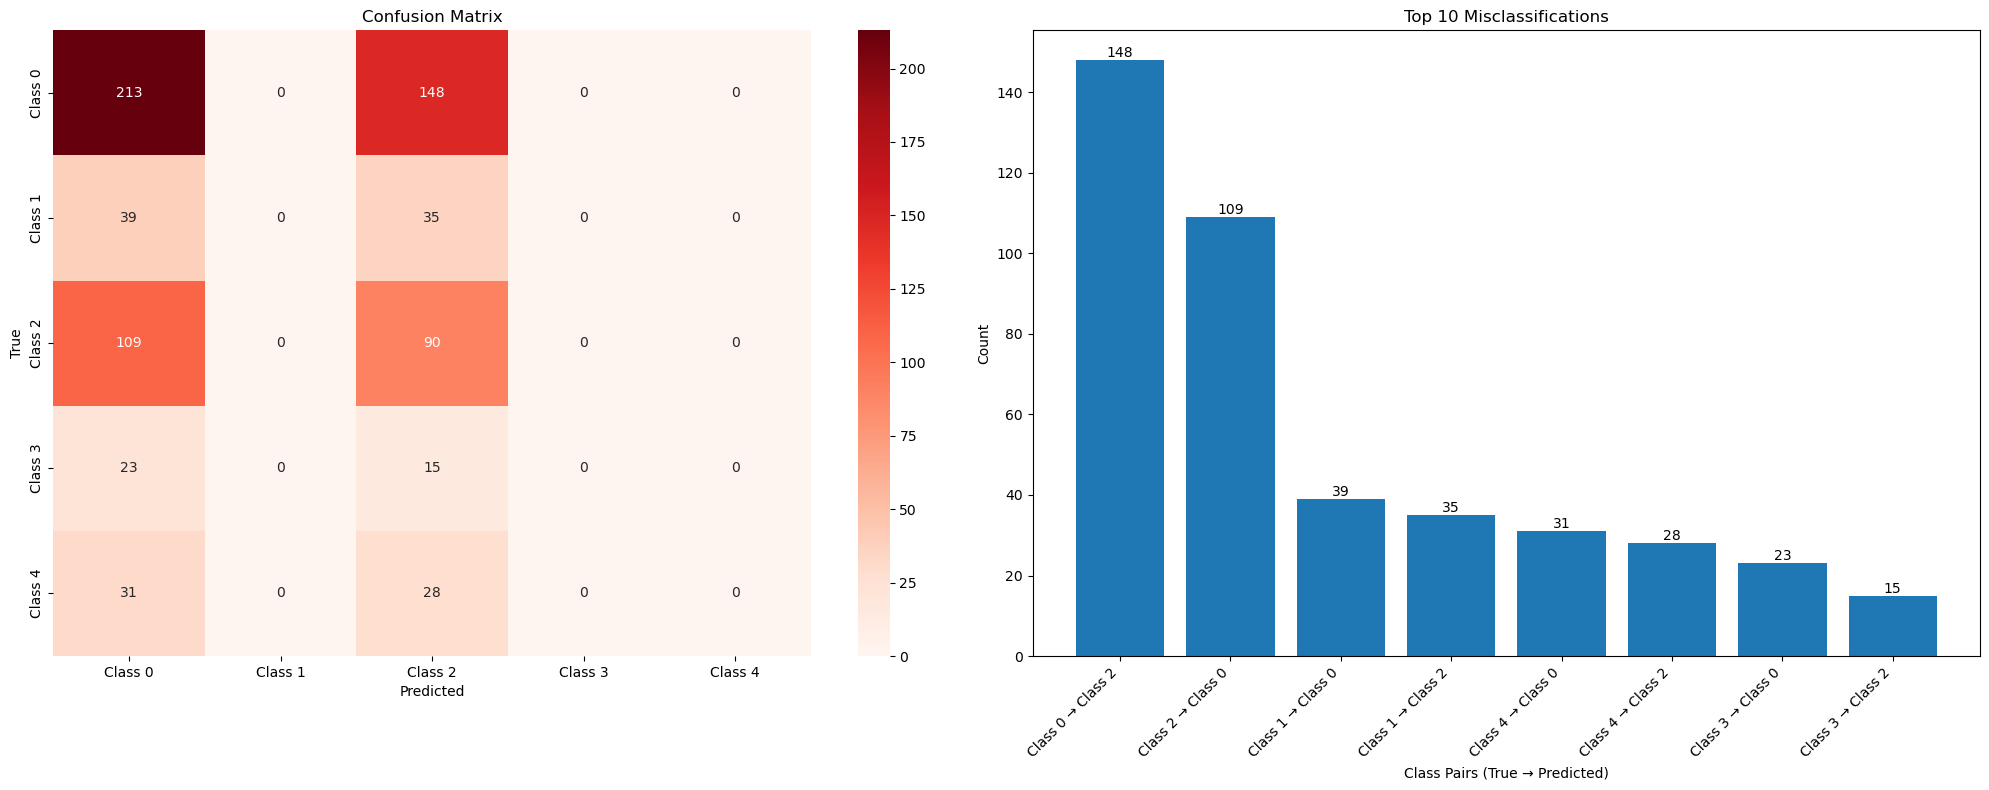

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss

# Get predictions for validation set
val_predictions = best_model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_true_classes = validation_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(val_true_classes, val_predicted_classes)

# Create figure with two subplots
plt.figure(figsize=(20, 8))

# 1. Raw Confusion Matrix (Misprediction Matrix)
plt.subplot(1, 2, 1)
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Reds',
            xticklabels=['Class '+str(i) for i in range(5)],
            yticklabels=['Class '+str(i) for i in range(5)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# 2. Misclassification Analysis
misclass_data = []
for true_class in range(5):
    for pred_class in range(5):
        if true_class != pred_class:
            count = cm[true_class][pred_class]
            if count > 0:
                misclass_data.append({
                    'True Class': f'Class {true_class}',
                    'Predicted Class': f'Class {pred_class}',
                    'Count': count,
                    'Percentage': (count / cm[true_class].sum()) * 100
                })

misclass_df = pd.DataFrame(misclass_data)
top_misclass = misclass_df.nlargest(10, 'Count')

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(top_misclass)), top_misclass['Count'])
plt.xticks(range(len(top_misclass)), 
          [f"{row['True Class']} → {row['Predicted Class']}" 
           for _, row in top_misclass.iterrows()],
          rotation=45,
          ha='right')
plt.title('Top 10 Misclassifications')
plt.xlabel('Class Pairs (True → Predicted)')
plt.ylabel('Count')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()



